# Advanced Modeling: Model Comparison
## Random Forest vs XGBoost vs LightGBM

This notebook compares three ensemble tree-based algorithms to determine which 
performs best for bank customer churn prediction.

**Objective:** Validate if XGBoost or LightGBM can outperform our Random Forest 
baseline (85.9% accuracy, 57.8% recall, 62.5% F1-score).

**Models to Compare:**
- Random Forest (baseline from 03_churn_prediction)
- XGBoost (gradient boosting)
- LightGBM (fast gradient boosting)

**Key Considerations:**
- All models use identical preprocessing (via `load_preprocessed_data()`)
- Same train/test split (random_state=42)
- Class imbalance handled consistently across models
- Performance metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path

# Sklearn models and utilities
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Advanced modeling algorithms
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Custom utilities
from advanced_modeling_utils import (
    load_preprocessed_data,
    compare_models_results,
    feature_importance_comparison,
    plot_roc_comparison,
    plot_confusion_matrices_comparison,
    save_experiment_results
)

# Settings
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Load Preprocessed Data

Use the utility function to load data with identical preprocessing as 
03_churn_prediction. This ensures fair comparison.

In [2]:
# Load data with consistent preprocessing
X_train, X_test, y_train, y_test, feature_names = load_preprocessed_data()

print(f"✓ Data loaded successfully")
print(f"\nData Summary:")
print(f"  Train shape: {X_train.shape}")
print(f"  Test shape: {X_test.shape}")
print(f"  Features: {len(feature_names)}")
print(f"  Train churn rate: {y_train.mean():.2%}")
print(f"  Test churn rate: {y_test.mean():.2%}")
print(f"\nFirst 5 features: {feature_names[:5]}")

✓ Data loaded successfully

Data Summary:
  Train shape: (8000, 13)
  Test shape: (2000, 13)
  Features: 13
  Train churn rate: 20.38%
  Test churn rate: 20.40%

First 5 features: ['gender', 'age', 'tenure', 'balance', 'numofproducts']


## 3. Baseline: Random Forest

Train Random Forest with the exact same hyperparameters as 03_churn_prediction
to establish our baseline performance.

**Model Parameters:**
- n_estimators=900
- max_depth=11
- criterion='gini'
- max_features=None
- min_samples_split=4
- min_samples_leaf=1
- class_weight={0:1, 1:2}
- random_state=42

In [3]:
print("="*80)
print("TRAINING BASELINE: RANDOM FOREST")
print("="*80)

rf_model = RandomForestClassifier(
    n_estimators=900,
    max_depth=11,
    criterion='gini',
    max_features=None,
    min_samples_split=4,
    min_samples_leaf=1,
    class_weight={0:1, 1:2},
    random_state=42,
    n_jobs=-1
)

print("\n🔨 Training Random Forest...")
rf_model.fit(X_train, y_train)
print("✓ Training complete")

# Evaluate Random Forest
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_roc = roc_auc_score(y_test, rf_proba)

print(f"\n📊 Random Forest Performance:")
print(f"  Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"  Precision: {rf_precision:.4f} ({rf_precision*100:.2f}%)")
print(f"  Recall:    {rf_recall:.4f} ({rf_recall*100:.2f}%)")
print(f"  F1-Score:  {rf_f1:.4f} ({rf_f1*100:.2f}%)")
print(f"  ROC-AUC:   {rf_roc:.4f} ({rf_roc*100:.2f}%)")

TRAINING BASELINE: RANDOM FOREST

🔨 Training Random Forest...
✓ Training complete

📊 Random Forest Performance:
  Accuracy:  0.8585 (85.85%)
  Precision: 0.6801 (68.01%)
  Recall:    0.5784 (57.84%)
  F1-Score:  0.6252 (62.52%)
  ROC-AUC:   0.8585 (85.85%)


## 4. XGBoost Model

Train XGBoost with similar hyperparameters to Random Forest for fair comparison.

**Key Parameters:**
- n_estimators=900 (same as RF)
- max_depth=6 (typical for XGBoost, often less than RF)
- learning_rate=0.05 (conservative, prevents overfitting)
- scale_pos_weight=2 (equivalent to class_weight={0:1, 1:2})
free_range

In [4]:
print("\n" + "="*80)
print("TRAINING XGBOOST")
print("="*80)

xgb_model = XGBClassifier(
    n_estimators=900,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=2,  # Equivalent to class_weight={0:1, 1:2}
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    verbosity=0  # Suppress XGBoost output
)

print("\n🔨 Training XGBoost...")
xgb_model.fit(X_train, y_train)
print("✓ Training complete")

# Evaluate XGBoost
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_roc = roc_auc_score(y_test, xgb_proba)

print(f"\n📊 XGBoost Performance:")
print(f"  Accuracy:  {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"  Precision: {xgb_precision:.4f} ({xgb_precision*100:.2f}%)")
print(f"  Recall:    {xgb_recall:.4f} ({xgb_recall*100:.2f}%)")
print(f"  F1-Score:  {xgb_f1:.4f} ({xgb_f1*100:.2f}%)")
print(f"  ROC-AUC:   {xgb_roc:.4f} ({xgb_roc*100:.2f}%)")


TRAINING XGBOOST

🔨 Training XGBoost...
✓ Training complete

📊 XGBoost Performance:
  Accuracy:  0.8405 (84.05%)
  Precision: 0.6115 (61.15%)
  Recall:    0.5980 (59.80%)
  F1-Score:  0.6047 (60.47%)
  ROC-AUC:   0.8428 (84.28%)


## 5. LightGBM Model

Train LightGBM with similar hyperparameters to the other models.

**Key Parameters:**
- n_estimators=900 (same as RF and XGBoost)
- max_depth=6 (typical for LightGBM)
- learning_rate=0.05 (same as XGBoost)
- scale_pos_weight=2 (equivalent to class_weight)
- verbose=-1 (suppress output)

In [5]:
print("\n" + "="*80)
print("TRAINING LIGHTGBM")
print("="*80)

lgbm_model = LGBMClassifier(
    n_estimators=900,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=2,  # Equivalent to class_weight={0:1, 1:2}
    random_state=42,
    n_jobs=-1,
    verbose=-1  # Suppress LightGBM output
)

print("\n🔨 Training LightGBM...")
lgbm_model.fit(X_train, y_train)
print("✓ Training complete")

# Evaluate LightGBM
lgbm_pred = lgbm_model.predict(X_test)
lgbm_proba = lgbm_model.predict_proba(X_test)[:, 1]

lgbm_accuracy = accuracy_score(y_test, lgbm_pred)
lgbm_precision = precision_score(y_test, lgbm_pred)
lgbm_recall = recall_score(y_test, lgbm_pred)
lgbm_f1 = f1_score(y_test, lgbm_pred)
lgbm_roc = roc_auc_score(y_test, lgbm_proba)

print(f"\n📊 LightGBM Performance:")
print(f"  Accuracy:  {lgbm_accuracy:.4f} ({lgbm_accuracy*100:.2f}%)")
print(f"  Precision: {lgbm_precision:.4f} ({lgbm_precision*100:.2f}%)")
print(f"  Recall:    {lgbm_recall:.4f} ({lgbm_recall*100:.2f}%)")
print(f"  F1-Score:  {lgbm_f1:.4f} ({lgbm_f1*100:.2f}%)")
print(f"  ROC-AUC:   {lgbm_roc:.4f} ({lgbm_roc*100:.2f}%)")


TRAINING LIGHTGBM

🔨 Training LightGBM...
✓ Training complete

📊 LightGBM Performance:
  Accuracy:  0.8425 (84.25%)
  Precision: 0.6165 (61.65%)
  Recall:    0.6029 (60.29%)
  F1-Score:  0.6097 (60.97%)
  ROC-AUC:   0.8416 (84.16%)


## 6. Model Comparison

Compare all three models side-by-side across key metrics.

In [6]:
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Create comparison table
comparison_results = {
    'Random Forest': (rf_pred, rf_proba),
    'XGBoost': (xgb_pred, xgb_proba),
    'LightGBM': (lgbm_pred, lgbm_proba)
}

comparison_df = compare_models_results(comparison_results, y_test)
print("\n")
print(comparison_df.to_string(index=False))


MODEL COMPARISON SUMMARY


        Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Random Forest    0.8585   0.680115 0.578431  0.625166 0.858506
      XGBoost    0.8405   0.611529 0.598039  0.604709 0.842771
     LightGBM    0.8425   0.616541 0.602941  0.609665 0.841605


In [7]:
# Sort by F1-Score (primary metric for imbalanced classification)
comparison_df_sorted = comparison_df.sort_values('F1-Score', ascending=False)
print("\n" + "="*80)
print("📊 RANKED BY F1-SCORE (Best for Imbalanced Data)")
print("="*80)
print(comparison_df_sorted.to_string(index=False))

# Identify best model
best_model = comparison_df_sorted.iloc[0]['Model']
best_f1 = comparison_df_sorted.iloc[0]['F1-Score']
print(f"\n🏆 Best Model by F1-Score: {best_model} ({best_f1:.4f})")


📊 RANKED BY F1-SCORE (Best for Imbalanced Data)
        Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Random Forest    0.8585   0.680115 0.578431  0.625166 0.858506
     LightGBM    0.8425   0.616541 0.602941  0.609665 0.841605
      XGBoost    0.8405   0.611529 0.598039  0.604709 0.842771

🏆 Best Model by F1-Score: Random Forest (0.6252)


## 7. Visualizations

Create visual comparisons of model performance.

### 7.1 Confusion Matrices Comparison

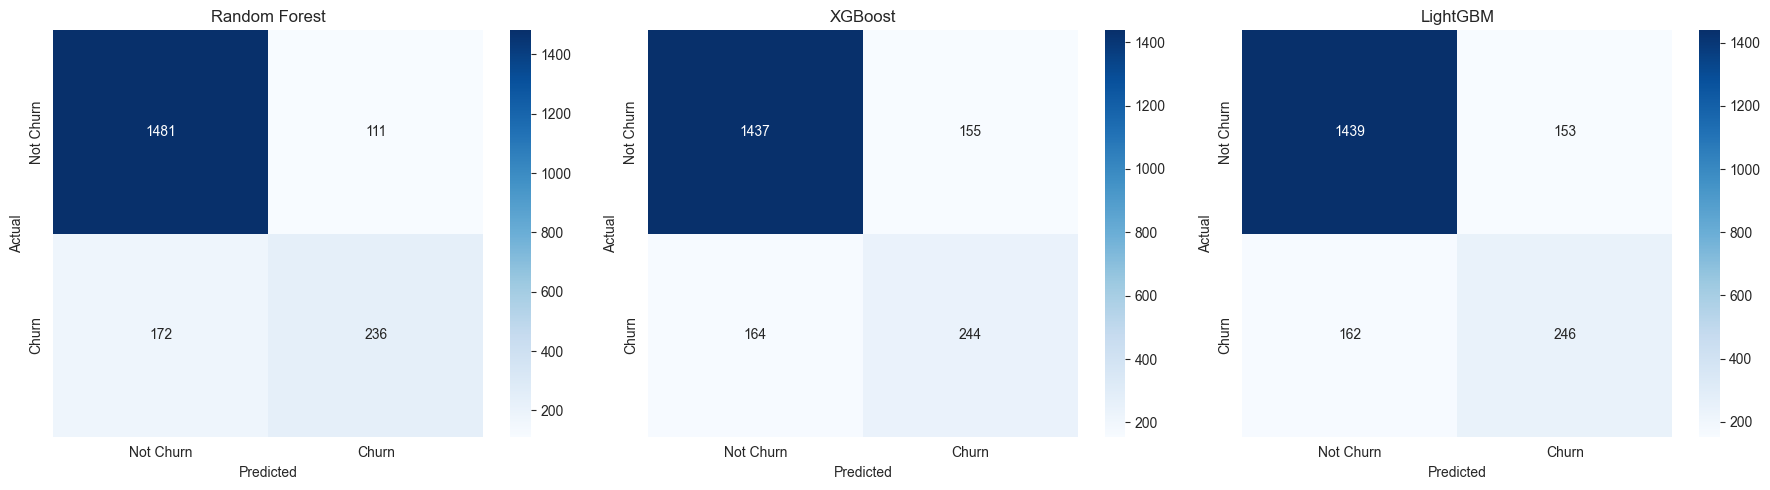

In [8]:
# Side-by-side confusion matrices
models_dict = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model
}

plot_confusion_matrices_comparison(models_dict, X_test, y_test, figsize=(18, 5))

### 7.2 ROC Curves Comparison

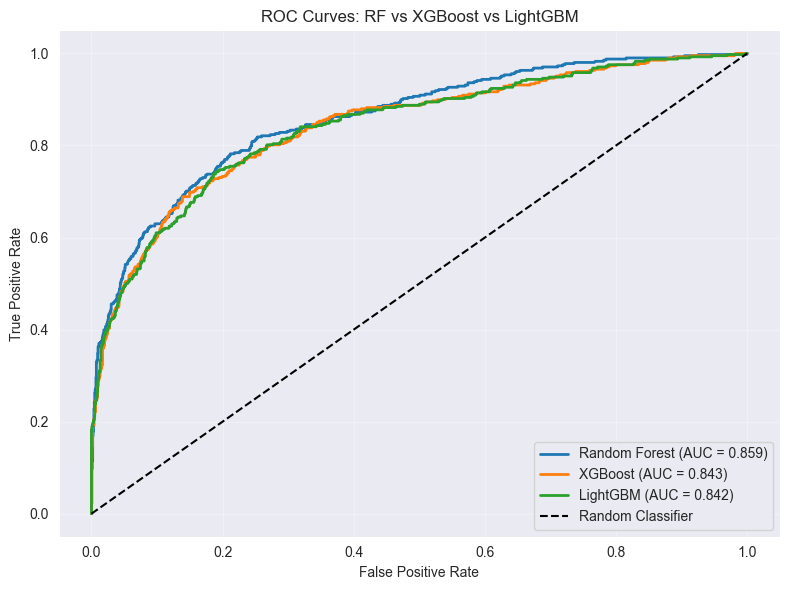

In [9]:
# Plot ROC curves for all models
plot_roc_comparison(models_dict, X_test, y_test, title="ROC Curves: RF vs XGBoost vs LightGBM")

### 7.3 Feature Importance Comparison

Compare which features each model considers most important.

<Figure size 1000x600 with 0 Axes>

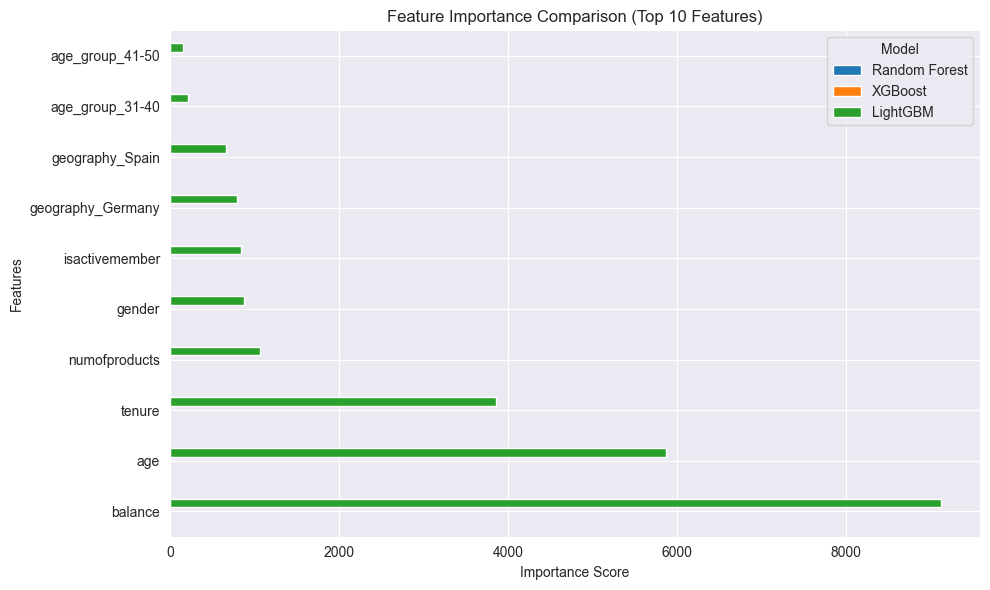

In [10]:
# Feature importance comparison
importance_df = feature_importance_comparison(models_dict, feature_names, top_n=10)

### 7.4 Metrics Bar Chart

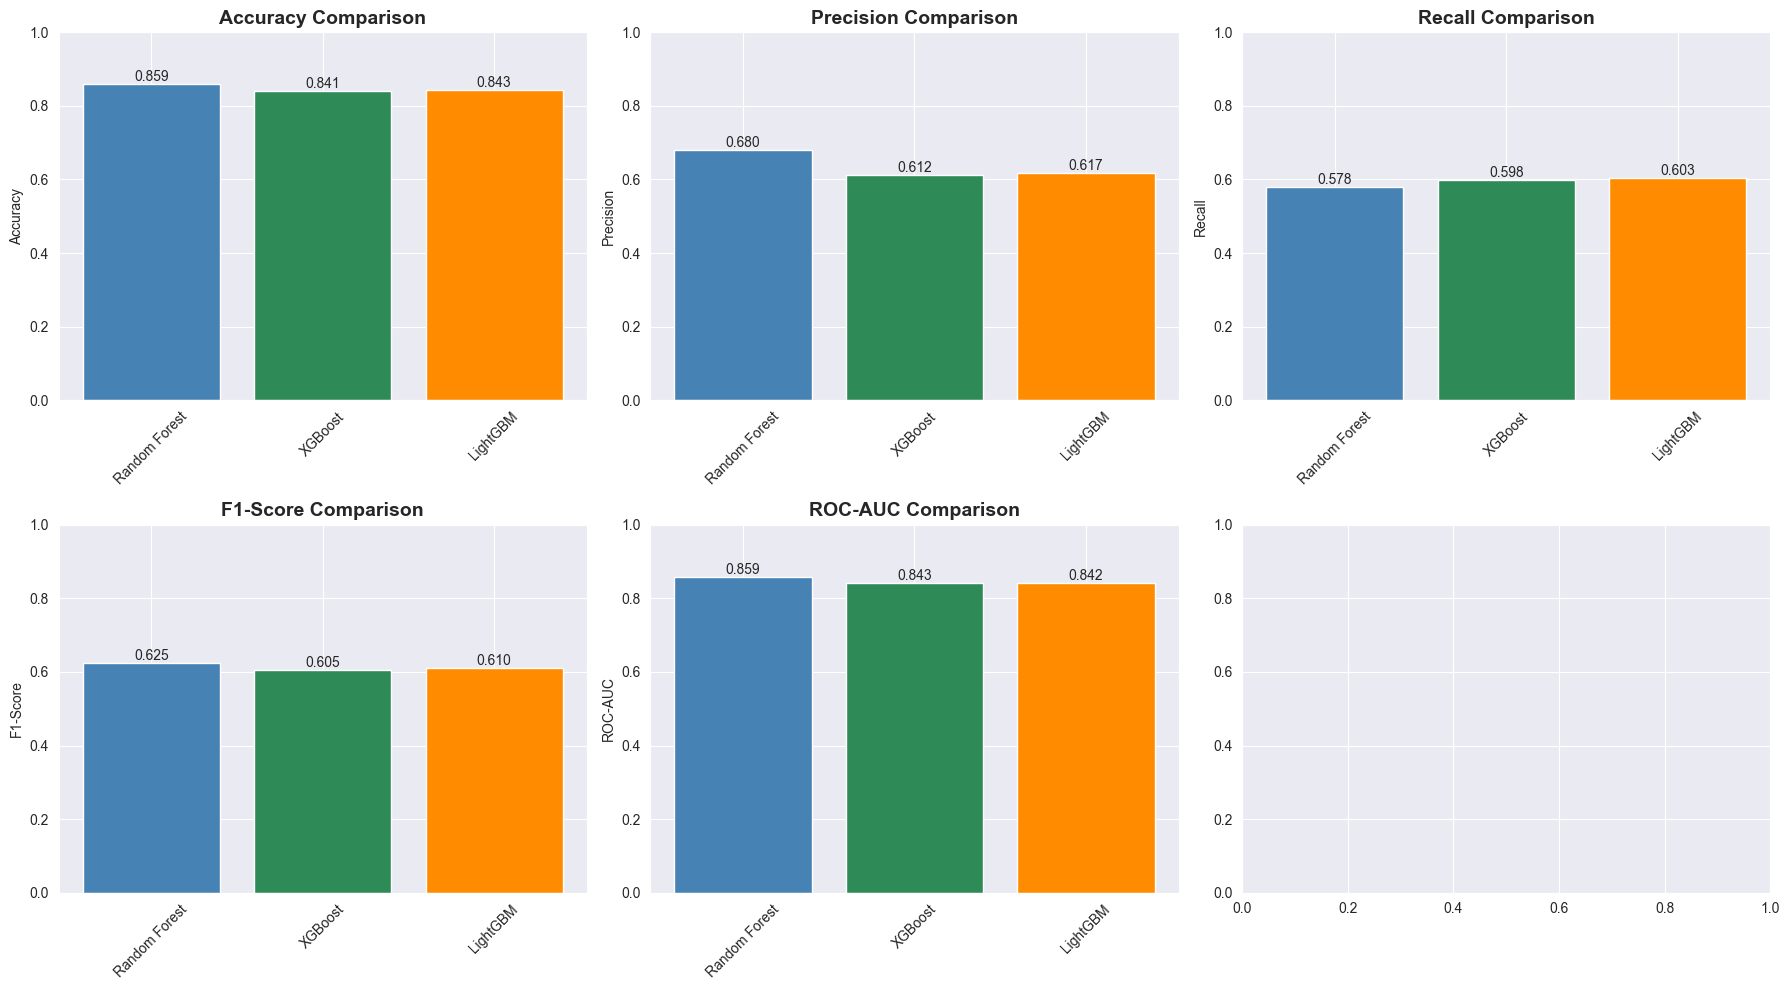

In [11]:
# Create bar chart comparing metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['steelblue', 'seagreen', 'darkorange']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = [comparison_df.loc[comparison_df['Model'] == model, metric].values[0] 
              for model in comparison_df['Model']]
    
    bars = ax.bar(comparison_df['Model'], values, color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Detailed Classification Reports

In [12]:
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for name, pred in zip(['Random Forest', 'XGBoost', 'LightGBM'], 
                       [rf_pred, xgb_pred, lgbm_pred]):
    print(f"\n{name}:")
    print(classification_report(y_test, pred, target_names=['Not Churn', 'Churn']))


DETAILED CLASSIFICATION REPORTS

Random Forest:
              precision    recall  f1-score   support

   Not Churn       0.90      0.93      0.91      1592
       Churn       0.68      0.58      0.63       408

    accuracy                           0.86      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.85      0.86      0.85      2000


XGBoost:
              precision    recall  f1-score   support

   Not Churn       0.90      0.90      0.90      1592
       Churn       0.61      0.60      0.60       408

    accuracy                           0.84      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000


LightGBM:
              precision    recall  f1-score   support

   Not Churn       0.90      0.90      0.90      1592
       Churn       0.62      0.60      0.61       408

    accuracy                           0.84      2000
   macro avg       0.76      0.75      0.76      2000
weig

## 9. Save Results

Save model comparison results for future reference.

In [13]:
# Prepare results dictionary
results = {
    'models': {
        'Random Forest': rf_model,
        'XGBoost': xgb_model,
        'LightGBM': lgbm_model
    },
    'predictions': {
        'Random Forest': rf_pred,
        'XGBoost': xgb_pred,
        'LightGBM': lgbm_pred
    },
    'probabilities': {
        'Random Forest': rf_proba,
        'XGBoost': xgb_proba,
        'LightGBM': lgbm_proba
    },
    'metrics': comparison_df.to_dict('records'),
    'feature_names': feature_names
}

# Save results
save_experiment_results(results, 'model_comparison_results.pkl')

✓ Results saved to results/model_comparison_results.pkl


## 10. Conclusions & Recommendations

Based on the comparison results:

In [14]:
print("\n" + "="*80)
print("CONCLUSIONS & RECOMMENDATIONS")
print("="*80)

# Calculate improvements vs Random Forest baseline
rf_baseline_f1 = comparison_df.loc[comparison_df['Model'] == 'Random Forest', 'F1-Score'].values[0]
rf_baseline_recall = comparison_df.loc[comparison_df['Model'] == 'Random Forest', 'Recall'].values[0]

xgb_f1_improvement = comparison_df.loc[comparison_df['Model'] == 'XGBoost', 'F1-Score'].values[0] - rf_baseline_f1
xgb_recall_improvement = comparison_df.loc[comparison_df['Model'] == 'XGBoost', 'Recall'].values[0] - rf_baseline_recall

lgbm_f1_improvement = comparison_df.loc[comparison_df['Model'] == 'LightGBM', 'F1-Score'].values[0] - rf_baseline_f1
lgbm_recall_improvement = comparison_df.loc[comparison_df['Model'] == 'LightGBM', 'Recall'].values[0] - rf_baseline_recall

print(f"\nRandom Forest Baseline:")
print(f"  F1-Score: {rf_baseline_f1:.4f}")
print(f"  Recall:   {rf_baseline_recall:.4f}")

print(f"\nXGBoost vs Baseline:")
print(f"  F1-Score change: {xgb_f1_improvement:+.4f} ({xgb_f1_improvement*100:+.2f}%)")
print(f"  Recall change:   {xgb_recall_improvement:+.4f} ({xgb_recall_improvement*100:+.2f}%)")

print(f"\nLightGBM vs Baseline:")
print(f"  F1-Score change: {lgbm_f1_improvement:+.4f} ({lgbm_f1_improvement*100:+.2f}%)")
print(f"  Recall change:   {lgbm_recall_improvement:+.4f} ({lgbm_recall_improvement*100:+.2f}%)")

print(f"\n{'='*80}")
print("RECOMMENDATION:")
print(f"{'='*80}")

if comparison_df_sorted.iloc[0]['Model'] == 'Random Forest':
    print("\n✓ Random Forest remains the best performing model.")
    print("  This validates our original choice in 03_churn_prediction.")
    print("  Consider Random Forest for deployment due to:")
    print("    - Best F1-Score and Recall")
    print("    - Good interpretability")
    print("    - Proven performance")
elif comparison_df_sorted.iloc[0]['Model'] == 'XGBoost':
    print("\n✓ XGBoost outperforms Random Forest.")
    print(f"  Improvement: F1 +{xgb_f1_improvement:.4f}, Recall +{xgb_recall_improvement:.4f}")
    print("  Consider XGBoost for deployment if:")
    print("    - Performance improvement is meaningful (>3% Recall)")
    print("    - Model complexity is acceptable")
elif comparison_df_sorted.iloc[0]['Model'] == 'LightGBM':
    print("\n✓ LightGBM outperforms Random Forest.")
    print(f"  Improvement: F1 +{lgbm_f1_improvement:.4f}, Recall +{lgbm_recall_improvement:.4f}")
    print("  Consider LightGBM for deployment if:")
    print("    - Performance improvement is meaningful (>3% Recall)")
    print("    - Faster training time is valuable")

print(f"\n{'='*80}")
print("END OF MODEL COMPARISON")
print(f"{'='*80}")


CONCLUSIONS & RECOMMENDATIONS

Random Forest Baseline:
  F1-Score: 0.6252
  Recall:   0.5784

XGBoost vs Baseline:
  F1-Score change: -0.0205 (-2.05%)
  Recall change:   +0.0196 (+1.96%)

LightGBM vs Baseline:
  F1-Score change: -0.0155 (-1.55%)
  Recall change:   +0.0245 (+2.45%)

RECOMMENDATION:

✓ Random Forest remains the best performing model.
  This validates our original choice in 03_churn_prediction.
  Consider Random Forest for deployment due to:
    - Best F1-Score and Recall
    - Good interpretability
    - Proven performance

END OF MODEL COMPARISON
